In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [20]:
with open('./cifar-10-batches-py/data_batch_1', 'rb') as fo:
    d = pickle.load(fo, encoding='bytes')

print(d.keys())
data = d[b'data']
labels = d[b'labels']
print(data[0])

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
[ 59  43  50 ... 140  84  72]


In [21]:
# takes 1D array of pixel data and converts to MxNx3 RGB format
def reshape_img(pixeldata, m, n):
    return np.rot90(pixeldata.reshape((m, n, 3), order='F'), 3)

In [22]:
image_data = [reshape_img(img, 32, 32) for img in data]

In [23]:
label_strs = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def class_str(class_index):
    return label_strs[class_index]

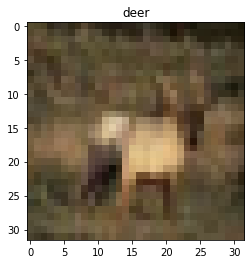

In [85]:
def display(image, index=-1):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    if index >= 0:
        ax.set_title(class_str(labels[index]))
    plt.imshow(image)
    plt.show()

display(image_data[3], 3)

In [136]:
# Adding this AFTER I've made the CNN forward prop: we need
# to convert the classes given to us to one-hot-encoded vectors

def one_hot(label, num_labels):
    oh = np.zeros((num_labels))
    oh[label] = 1
    return oh

print(one_hot(5, 10))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [114]:
# Great, so now we have our image data in a good format. 

# Let's first try to make sense of how a CNN is structured

# We'll separate our data into training and testing groups later

### Convolutional Neural Network (CNN)
We have our input image, structured in a MxNx3 format (3 dimensions for R, G, and B values) 

The input image generally feeds directly into a convolutional layer. A convolutional layer is made up of multiple filters, each of the same size. Filters have a size, let's say fxf, where each value is a weight. We can think of the filters as a sort of sliding window that goes across and down its input. The filters also have a "stride," which is a measure of how quickly the filter "slides" across its input (ie. how many pixels does it jump)

Let's say we have F filters. S = stride. The output layer will be of size ((InpSize - F)/S + 1). 

In [359]:
# Okay then, we'll attempt a convolutional layer.

class ConvLayer:
    
    def __init__(self, num_filters, filter_size, stride=1):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.stride = stride
        
        # initialize filters randomly (divide by filter_size^2 to normalize)
        self.filters = np.random.randn(num_filters, filter_size, filter_size) / (filter_size**2)
        # self.filters = [[[0.1, 0.1], [0.1, 0.1]], [[0.2, 0.2], [0.2, 0.2]]]
    
    
    '''
    convolve takes a filter-sized patch of the image,
    a filter itself, and performs the convolve operation,
    returning a single sum
    '''
    def convolve(self, patch, f):
        s = 0
        height, width, depth = patch.shape
        for d in range(depth):
            for h in range(height):
                for w in range(width):
                    s += f[h][w]*patch[h][w][d]
        return s
    
    
    '''
    get_patch returns a filter-sized patch of the image,
    given an i,j coordinate (upper-left pixel)
    '''
    def get_patch(self, image, i, j):
        return image[i:(i+self.filter_size), j:(j+self.filter_size)]
        
    
    '''
    Forward propagation
    '''
    def forward_prop(self, image):
        self.image = image
        
        height, width, d = image.shape
        h_strides = int((width - self.filter_size) / self.stride + 1)
        v_strides = int((height - self.filter_size) / self.stride + 1)
        
        self.out_size = (h_strides, v_strides, self.num_filters)
        conv_out = np.zeros(self.out_size)
        
        for f, fltr in enumerate(self.filters):
            for i in range(0, v_strides):
                for j in range(0, h_strides):
                    conv_out[i, j, f] = self.convolve(self.get_patch(image, i*self.stride, j*self.stride), fltr)
        return conv_out
    
    '''
    Backward propagation
    dL_dout - will be the gradients from the next ConvLayer
            (or the softmax layer if this is the last ConvLayer)
    learning_rate - parameter for updating weights 
    '''
    def backward_prop(self, dL_dout, learning_rate):
        dL_dW_params = np.zeros(self.filters.shape)
        
        h, w, d = self.image.shape
        h_strides, v_strides, nfilters = self.out_size   
        
        for i in range(h_strides):
            for j in range(v_strides):
                for f in range(nfilters):
                    for layer in range(d):
                        dL_dW_params[f] += self.get_patch(self.image, i, j)[:,:,layer] * dL_dout[i][j][f]

        self.filters -= learning_rate * dL_dW_params
        return dL_dW_params
        

In [360]:
# this is just a quick test of the forward prop math
L = ConvLayer(2, 2)
test_img = np.array([
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ],
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ],
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ],
])
print(test_img.shape)
print(L.forward_prop(test_img))

(3, 3, 3)
[[[ 4.62435078  0.72121803]
  [ 6.94628208 -2.72895623]]

 [[ 4.62435078  0.72121803]
  [ 6.94628208 -2.72895623]]]


(29, 29, 10)


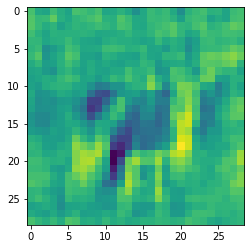

In [361]:
L = ConvLayer(10, 4)
conv_out = L.forward_prop(image_data[3])
print(conv_out.shape)

# output of a single conv layer (one slice)
plt.imshow(conv_out[:,:,9])

In [362]:
# At the end of our sequence of ConvLayers, we'll need to flatten
# whatever output we get, in order to be fed into a softmax layer

# It doesn't *exactly* matter how we go about flattening this layer.
# The model will learn the patterns regardless of this layer's ordering
# (at least I think)

# EDIT: I'm just going to include this in the Softmax layer
# EDIT2: numpy has a built-in flatten function, I'll use that instead

def flatten(conv_out):
    height, width, depth = conv_out.shape
    out = np.zeros((height*width*depth,))
    i = 0
    for d in range(depth):
        for h in range(height):
            for w in range(width):
                out[i] = conv_out[h][w][d]
                i += 1
    
    return out

print(flatten(np.array([
    [
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ]
])))

print(np.array([
    [
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ]
]).flatten())

[1. 4. 7. 2. 5. 8. 3. 6. 9.]
[1 2 3 4 5 6 7 8 9]


In [384]:
# After the convolutional layer, we'll want to put our image thru
# a pooling layer. 

class MaxPoolLayer:
    
    def __init__(self, filter_size):
        self.filter_size = filter_size
        
    
    '''
    * used from ConvLayer *
    get_patch returns a filter-sized patch of the image,
    given an i,j coordinate (upper-left pixel)
    '''
    def get_patch(self, image, i, j):
        return image[i:(i+self.filter_size), j:(j+self.filter_size)]
    
    
    def forward_prop(self, image):
        self.image = image
        height, width, nfilters = image.shape
        
        self.out_size = (height // self.filter_size, width // self.filter_size, nfilters)
        out = np.zeros(self.out_size)
        
        for i in range(self.out_size[0]):
            for j in range(self.out_size[1]):
                out[i][j] = np.amax(self.get_patch(image, i*self.filter_size, j*self.filter_size), axis=(0,1))
                
        return out
    
    def backward_prop(self, dL_dout, learning_rate):
        dL_dMP = np.zeros(self.image.shape)
        height, width, nfilters = self.out_size
        
        for i in range(height):
            for j in range(width):
                image_patch = self.get_patch(self.image, i*self.filter_size, j*self.filter_size)
                max_val = np.amax(image_patch, axis=(0,1))
                h, w, f = image_patch.shape
                
                # iterate over inp image and 
                for ip in range(h):
                    for jp in range(w):
                        for fp in range(f):
                            if image_patch[ip][jp][fp] == max_val[fp]:
                                dL_dMP[i*self.filter_size + ip][j*self.filter_size + jp][fp] = dL_dout[i, j, fp]
                                
        return dL_dMP
        

In [385]:
# Let's test out forward prop

img = image_data[5]
Conv = ConvLayer(4, 4, 2)
MP = MaxPoolLayer(2)
conv_out = Conv.forward_prop(img)
mp_out = MP.forward_prop(conv_out)

print(conv_out.shape)
print(mp_out.shape)

(15, 15, 4)
(7, 7, 4)


In [429]:
# Now I guess we can start creating our softmax layer. 

# This layer takes a single-dimensional input, and gives an 
# output of size C, where C is # of classes we're training

class SoftmaxLayer:
    
    '''
    num_inputs - the total size of the output of the previous ConvLayer
    num_classes - number of classes we are training to predict
    '''
    def __init__(self, num_inputs, num_classes):
        
        # initialize weights & biases
        self.weights = np.random.randn(num_inputs, num_classes) / num_inputs
        self.biases = np.zeros(num_classes)
    
    
    '''
    Forward propagation, Softmax layer
    
    img - will be the "box" of z outputs from the last ConvLayer
    '''
    def forward_prop(self, img):
        
        # these will be used in backward propagation
        self.orig_img_shape = img.shape
        self.flattened = img.flatten()
        
        # this is our z values out of the FC layer
        self.output = np.dot(self.flattened, self.weights) + self.biases
        print('weights at FC layer: ', self.weights)
        
        # e^(z_i)
        exp_out = np.exp(self.output)
        
         # this is our y_hat predictions
        return exp_out / np.sum(exp_out, axis=0)
    
    
    '''
    Backward propagation, Softmax layer
    
    dL_dout - will be given from our model's main function - it is
    going to be the cross-entropy loss
    
    learning_rate - model's learning rate
    '''
    def backward_prop(self, dL_dout, learning_rate):
        for i, grad in enumerate(dL_dout):
            if grad == 0:
                continue
            
            exp = np.exp(self.output)
            S_total = np.sum(exp)
            
            # case 2: i != l
            dy_dz = -exp[i] * exp / (S_total**2)
            
            # case 1: i == l (this is equiv. to y*(1-y))
            dy_dz[i] = exp[i]*(S_total - exp[i]) / (S_total**2)
            
            # dz_dw, dz_db, dz_dinput
            dz_dw = self.flattened
            dz_db = 1
            dz_dinput = self.weights
            
            # grad is dL_dy
            # dL/dz = dL/dy * dy/dz
            dL_dz = grad * dy_dz
            
            # loss wrt. weights, biases, input
            dL_dW = np.dot(dz_dw[np.newaxis].T, dL_dz[np.newaxis])
            dL_db = dL_dz * dz_db
            dL_dinput = np.dot(dz_dinput, dL_dz)
            
            # update weights and biases
            self.weights = self.weights - (learning_rate * dL_dW)
            self.biases = self.biases - (learning_rate * dL_db)
            
            return dL_dinput.reshape(self.orig_img_shape)
            

In [430]:
from math import prod
sm = SoftmaxLayer(prod(conv_out.shape), 10)
softmax_out = sm.forward_prop(conv_out)

print(softmax_out)


weights at FC layer:  [[-1.05325120e-03 -1.07922720e-03  7.02093039e-04 ... -1.99389983e-03
   2.81271563e-03  2.65365204e-05]
 [ 4.18169580e-04 -1.65011190e-03  1.18014226e-03 ...  8.39622602e-04
  -1.65898035e-03 -1.55978072e-04]
 [-2.08837427e-03  2.30559608e-04  1.02723699e-03 ... -7.92848701e-04
  -6.67843925e-04  1.07044534e-03]
 ...
 [ 1.76552817e-04 -1.37173080e-03 -6.73392962e-04 ... -2.69576899e-05
  -7.48681766e-04  1.70139507e-04]
 [-2.94353535e-04 -5.63570860e-04  1.04538514e-04 ...  1.16461534e-03
  -1.35985839e-03  2.36914062e-04]
 [-3.37059726e-04 -8.64856355e-04  1.91783161e-03 ... -3.08085474e-04
  -3.46254705e-05  1.14438714e-03]]
[3.78687738e-03 5.40165568e-03 2.43269007e-03 8.38830570e-06
 1.36489901e-02 4.92509876e-02 1.27377362e-01 7.52091263e-01
 8.56289026e-05 4.59161573e-02]


In [426]:
# Test run of one image forward prop thru whole model

img = image_data[5]
Conv1 = ConvLayer(num_filters=4, filter_size=4, stride=1)
MP1 = MaxPoolLayer(2)

# forward prop thru ConvLayers
c1_out = Conv1.forward_prop(img)
mp1_out = MP1.forward_prop(c1_out)

print(mp1_out.shape)

# softmax
softmax = SoftmaxLayer(prod(mp1_out.shape), 10)
softmax_out = softmax.forward_prop(mp1_out)

print(softmax_out)

(14, 14, 4)
weights at FC layer:  [[-8.62362156e-04 -2.95377280e-03  3.10550766e-05 ...  3.05297520e-04
   1.77731915e-03  8.68463525e-04]
 [-1.19893126e-03  1.07681010e-04  6.71452874e-04 ... -2.68097665e-04
  -6.71370352e-04 -2.25809389e-04]
 [-6.86910617e-04  7.08813215e-04  3.66301270e-04 ...  1.30200698e-04
   8.98149637e-04 -1.06507315e-03]
 ...
 [ 1.93160686e-05  3.94636198e-04 -2.88761908e-03 ...  2.19485918e-03
   8.46884610e-04  1.50429019e-03]
 [-1.03632897e-04 -1.12836819e-03 -1.85546182e-03 ...  1.22972652e-03
   1.42385982e-04  1.42251918e-03]
 [-5.44770090e-04 -2.36933939e-03  6.49693906e-04 ...  3.89019474e-04
  -2.84408445e-04 -1.34084314e-03]]
[3.23186297e-02 1.33933556e-01 5.10569468e-06 7.59760924e-02
 9.28842207e-02 6.43614006e-02 4.32927662e-02 5.22308439e-01
 3.36957877e-02 1.22400260e-03]


### Calculating Cross-Entropy Loss
Cross-entropy loss: 


In [427]:
# Test run of one image thru backpropagation

learning_rate = 0.01

l = 5
oh_l = one_hot(labels[l], 10)
cross_entropy_loss = -np.log(softmax_out[l])
accuracy = 0
if np.argmax(softmax_out) == l:
    accuracy = 1
    
gradient = np.zeros(10)
gradient[l] = -1/softmax_out[l]

backprop = softmax.backward_prop(gradient, learning_rate)
backprop = MP1.backward_prop(backprop, learning_rate)
backprop = Conv1.backward_prop(backprop, learning_rate)
print('conv backprop gradients shape: ', backprop.shape)

print(cross_entropy_loss, accuracy)

conv backprop gradients shape:  (4, 4, 4)
2.743241195764948 0


### Now we have a 1-layer CNN
Let's try to train it

In [428]:
train_images = image_data[:9000]
test_images = image_data[9000:]

train_labels = labels[:9000]
test_labels = labels[9000:]

class CNNModel:
    def __init__(self, layers, num_classes, learning_rate=0.01):
        assert len(layers) >= 1
        self.layers = layers
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        
    def forward_prop(self, image, label):
        out_forward = self.layers[0].forward_prop(image)
        for layer in self.layers[1:]:
            out_forward = layer.forward_prop(out_forward)
        
        cross_entropy_loss = -np.log(out_forward[label])
        accuracy = 0
        if np.argmax(out_forward) == label:
            accuracy = 1
        
        return out_forward, cross_entropy_loss, accuracy
    
    def backward_prop(self, initial_gradient):
        back_gradient = self.layers[-1].backward_prop(initial_gradient, self.learning_rate)
        for layer in reversed(self.layers[:-1]):
            back_gradient = layer.backward_prop(back_gradient, self.learning_rate)
    
    def train_image(self, image, label):
        
        # Forward propagation
        out_fw, loss, acc = self.forward_prop(image, label)
        
        print('forward out: ', out_fw, 'sum: ', sum(out_fw))
        # calc initial gradient
        gradient = np.zeros(self.num_classes)
        gradient[label] = -1 / out_fw[label]
        
        # Backward propagation
        self.backward_prop(gradient)
        
        return loss, acc
    

model_test = CNNModel(
    layers=[
        ConvLayer(4,4),
        MaxPoolLayer(2),
        SoftmaxLayer(784, 10)
    ],
    num_classes=10,
    learning_rate=0.01
)

num_epochs = 1

for epoch in range(num_epochs):
    
    num_correct = 0
    loss = 0
    
    for i, (image, label) in enumerate(zip(train_images, train_labels)):
        l, a = model_test.train_image(image, label)
        
        loss += l
        num_correct += a
        
        if i % 100 == 0:
            print('after {steps} steps: num_correct: {acc}, avg loss: {loss}'.format(steps=i, acc=num_correct, loss=loss))
            loss = 0
            num_correct = 0

weights at FC layer:  [[-8.74013861e-04  1.69327560e-03 -8.84335788e-04 ...  1.19728204e-03
  -6.79668293e-04  1.32695885e-04]
 [ 1.51890615e-03 -1.69643185e-03  1.07172519e-03 ... -1.08536080e-03
   1.36338673e-03  7.19451576e-04]
 [ 6.19617335e-04 -1.10628798e-03 -6.45858076e-04 ...  1.15246054e-03
  -9.85515770e-04 -4.42297131e-04]
 ...
 [-2.58157777e-04 -2.82072811e-03 -1.09964190e-05 ...  9.14528953e-04
  -1.96960280e-03 -8.14536781e-04]
 [-3.06578577e-04 -1.10318950e-03  9.70848925e-05 ...  6.52769368e-04
   2.16287257e-03 -1.17868223e-03]
 [ 2.98540479e-04  1.05306438e-03 -1.45530873e-04 ...  7.20888915e-04
  -9.58220684e-04 -3.41078190e-04]]
forward out:  [1.62330482e-03 6.17739141e-02 1.36888437e-02 9.05270569e-02
 2.79815192e-02 6.23502311e-05 1.24622811e-03 1.08553225e-04
 7.31804385e-01 7.11838447e-02] sum:  1.0
after 0 steps: num_correct: 0, avg loss: 6.6876337993683155
weights at FC layer:  [[-7.95381515e-04  4.68558346e-03 -2.21252750e-04 ...  1.20254032e-03
   3.4768692

<ipython-input-424-91745d3b8370>:35: RuntimeWarning: overflow encountered in exp
  exp_out = np.exp(self.output)
<ipython-input-424-91745d3b8370>:38: RuntimeWarning: invalid value encountered in true_divide
  return exp_out / np.sum(exp_out, axis=0)
<ipython-input-424-91745d3b8370>:54: RuntimeWarning: overflow encountered in exp
  exp = np.exp(self.output)
<ipython-input-424-91745d3b8370>:58: RuntimeWarning: invalid value encountered in multiply
  dy_dz = -exp[i] * exp / (S_total**2)
<ipython-input-424-91745d3b8370>:58: RuntimeWarning: invalid value encountered in true_divide
  dy_dz = -exp[i] * exp / (S_total**2)
<ipython-input-424-91745d3b8370>:61: RuntimeWarning: invalid value encountered in double_scalars
  dy_dz[i] = exp[i]*(S_total - exp[i]) / (S_total**2)


weights at FC layer:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
forward out:  [nan nan nan nan nan nan nan nan nan nan] sum:  nan
weights at FC layer:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
forward out:  [nan nan nan nan nan nan nan nan nan nan] sum:  nan
weights at FC layer:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
forward out:  [nan nan nan nan nan nan nan nan nan nan] sum:  nan
weights at FC layer:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan

KeyboardInterrupt: 